In [0]:
#downloading data
"""!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!pip install --upgrade --force-reinstall -- kaggle
!kaggle competitions download -c competitive-data-science-predict-future-sales -p /content/
import os
os.chdir('../content/')  #change dir
!unzip -q competitive-data-science-predict-future-sales.zip   #unzip data /"""

"!pip install -q kaggle\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json  # set permission\n!pip install --upgrade --force-reinstall -- kaggle\n!kaggle competitions download -c competitive-data-science-predict-future-sales -p /content/\nimport os\nos.chdir('../content/')  #change dir\n!unzip -q competitive-data-science-predict-future-sales.zip   #unzip data /"

In [0]:
#useful frameworks
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from xgboost import XGBRegressor
from xgboost import plot_importance

In [0]:
#import data
train = pd.read_csv("/content/sales_train.csv")
shops = pd.read_csv("/content/shops.csv")
items = pd.read_csv("/content/items.csv")
item_categories = pd.read_csv("/content/item_categories.csv")
test = pd.read_csv("/content/test.csv")

In [0]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [0]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [0]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [0]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [0]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [0]:
#same shops with different id
train.loc[train["shop_id"] == 0, "shop_id"] = 57
test.loc[test["shop_id"] == 0, "shop_id"] = 57


train.loc[train["shop_id"] == 1, "shop_id"] = 58
test.loc[test["shop_id"] == 1, "shop_id"] = 58


train.loc[train["shop_id"] == 10, "shop_id"] = 11
test.loc[test["shop_id"] == 10, "shop_id"] = 11

train.loc[train["shop_id"] == 39, "shop_id"] = 40
test.loc[test["shop_id"] == 39, "shop_id"] = 40

In [0]:
#drop shops/ items not in test
train_shop_ids = train["shop_id"].unique()
test_shop_ids = test["shop_id"].unique()

train_item_ids = train["item_id"].unique()
test_item_ids = test["item_id"].unique()


train = train[train["shop_id"].isin(test_shop_ids)]
train = train[train["item_id"].isin(test_item_ids)]

In [0]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,1.230912e+06,1.230912e+06,1.230912e+06,1.230912e+06,1.230912e+06
mean,1.931270e+01,3.224172e+01,9.623090e+03,1.029337e+03,1.320515e+00
std,9.135343e+00,1.646919e+01,6.302315e+03,1.823975e+03,3.304733e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,5.000000e-01,-1.600000e+01
25%,1.200000e+01,2.100000e+01,4.181000e+03,2.990000e+02,1.000000e+00
50%,2.100000e+01,3.100000e+01,7.856000e+03,5.492083e+02,1.000000e+00
75%,2.700000e+01,4.600000e+01,1.523800e+04,1.199000e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,5.920000e+04,2.169000e+03


In [0]:
train[train["item_cnt_day"] <= 0].item_cnt_day.value_counts()

-1.0     2903
-2.0       33
-3.0        9
-5.0        2
-4.0        2
-16.0       1
-6.0        1
Name: item_cnt_day, dtype: int64

In [0]:
#fix some typos
train.loc[train["item_cnt_day"] == -1.0, "item_cnt_day"] = 1.0
train = train[train["item_cnt_day"] >= 0]

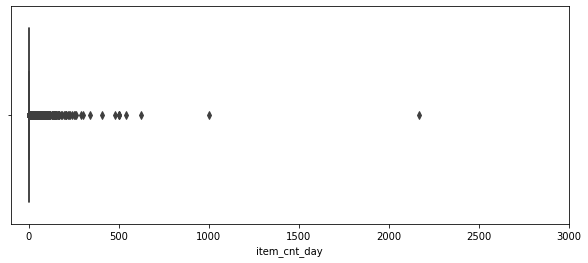

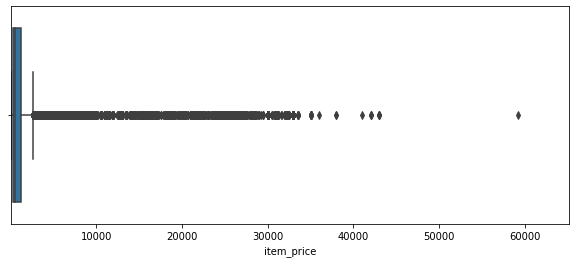

In [0]:
#remove outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


train = train[train.item_price<1800]
train = train[train.item_cnt_day<10]

In [0]:
shop_ids = test["shop_id"].unique()
shop_ids.sort()
item_ids = test["item_id"].unique() # use test, not train, because test contains extra items
item_ids.sort()
date_block_nums = train["date_block_num"].unique()
date_block_nums.sort()

all_shop_items = []
for shop_id in shop_ids:
    for item_id in item_ids:
        for date_block_num in date_block_nums:
            all_shop_items.append([shop_id, item_id, date_block_num])

all_shop_items = pd.DataFrame(np.array(all_shop_items), columns = ["shop_id", "item_id", "date_block_num"])

In [0]:
train_monthly = train.groupby(["shop_id", "item_id", "date_block_num"]).agg(item_cnt_month = ("item_cnt_day", "sum"), item_price_month = ("item_price", "mean"))

In [0]:
train_monthly.head()

item_cnt_month  item_price_month
shop_id item_id date_block_num                                  
2       30      2                          1.0             359.0
                5                          1.0             399.0
                15                         1.0             169.0
                16                         1.0             169.0
        31      1                          4.0             699.0

In [0]:
train_monthly["item_cnt_month"] = train_monthly["item_cnt_month"].clip(0, 20)

In [0]:
train_monthly = all_shop_items.merge(train_monthly, how = "left", on = ["shop_id", "item_id", "date_block_num"]).fillna(0)

In [0]:
train_monthly.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month
0,2,30,0,0.0,0.0
1,2,30,1,0.0,0.0
2,2,30,2,1.0,359.0


In [0]:
X_train = train_monthly.pivot_table(index = ["shop_id", "item_id"], columns = "date_block_num", values = ["item_cnt_month", "item_price_month"]).fillna(0)

In [0]:
X_train.head(3)

item_cnt_month                      ... item_price_month                        
date_block_num              0    1    2    3    4   ...               29   30     31   32     33
shop_id item_id                                     ...                                         
2       30                 0.0  0.0  1.0  0.0  0.0  ...              0.0  0.0    0.0  0.0    0.0
        31                 0.0  4.0  1.0  1.0  0.0  ...              0.0  0.0    0.0  0.0  399.0
        32                 0.0  0.0  0.0  0.0  0.0  ...              0.0  0.0  149.0  0.0    0.0

[3 rows x 68 columns]

In [0]:
X_train.columns = [x[0] + "_" + str(x[1]) for x in X_train.columns.ravel()]
X_train = X_train.reset_index().rename_axis(None, axis = 1)

In [0]:
X_train.head(3)

,shop_id,item_id,item_cnt_month_0,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_cnt_month_4,item_cnt_month_5,item_cnt_month_6,item_cnt_month_7,item_cnt_month_8,item_cnt_month_9,item_cnt_month_10,item_cnt_month_11,item_cnt_month_12,item_cnt_month_13,item_cnt_month_14,item_cnt_month_15,item_cnt_month_16,item_cnt_month_17,item_cnt_month_18,item_cnt_month_19,item_cnt_month_20,item_cnt_month_21,item_cnt_month_22,item_cnt_month_23,item_cnt_month_24,item_cnt_month_25,item_cnt_month_26,item_cnt_month_27,item_cnt_month_28,item_cnt_month_29,item_cnt_month_30,item_cnt_month_31,item_cnt_month_32,item_cnt_month_33,item_price_month_0,item_price_month_1,item_price_month_2,item_price_month_3,item_price_month_4,item_price_month_5,item_price_month_6,item_price_month_7,item_price_month_8,item_price_month_9,item_price_month_10,item_price_month_11,item_price_month_12,item_price_month_13,item_price_month_14,item_price_month_15,item_price_month_16,item_price_month_17,item_price_month_18,item_price_month_19,item_price_month_20,item_price_month_21,item_price_month_22,item_price_month_23,item_price_month_24,item_price_month_25,item_price_month_26,item_price_month_27,item_price_month_28,item_price_month_29,item_price_month_30,item_price_month_31,item_price_month_32,item_price_month_33
0,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,359.0,0.0,0.0,399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,169.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,699.0,698.5,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399.0
2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,0.0,149.0,0.0,0.00,0.0,149.0,0.0,149.0,149.0,0.0,149.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0


In [0]:
item_categories["supercat"] = item_categories["item_category_name"].str.partition(' - ')[0]
item_categories["subcat"] = item_categories["item_category_name"].str.partition(' - ')[2]

item_categories.loc[item_categories["subcat"] == "", "subcat"] = item_categories["supercat"]

In [0]:
item_categories.head(3)

,item_category_name,item_category_id,supercat,subcat
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3


In [0]:
encoded_cats = item_categories.copy()
encoded_cats = pd.concat([encoded_cats, pd.get_dummies("supercat_" + encoded_cats["supercat"])], axis = 1)
encoded_cats = pd.concat([encoded_cats, pd.get_dummies("subcat_" + encoded_cats["subcat"])], axis = 1)
encoded_cats = encoded_cats.drop(["item_category_name", "supercat", "subcat"], axis = 1)
encoded_cats.head(3)

,item_category_id,supercat_PC,supercat_Аксессуары,supercat_Билеты (Цифра),supercat_Доставка товара,supercat_Игровые консоли,supercat_Игры,supercat_Игры Android,supercat_Игры MAC,supercat_Игры PC,supercat_Карты оплаты,"supercat_Карты оплаты (Кино, Музыка, Игры)",supercat_Кино,supercat_Книги,supercat_Музыка,supercat_Подарки,supercat_Программы,supercat_Служебные,supercat_Чистые носители (шпиль),supercat_Чистые носители (штучные),supercat_Элементы питания,subcat_1С:Предприятие 8,subcat_Blu-Ray,subcat_Blu-Ray 3D,subcat_Blu-Ray 4K,subcat_CD локального производства,subcat_CD фирменного производства,subcat_DVD,subcat_Live!,subcat_Live! (Цифра),subcat_MAC (Цифра),subcat_MP3,subcat_PS2,subcat_PS3,subcat_PS4,subcat_PSN,subcat_PSP,subcat_PSVita,subcat_Windows (Цифра),subcat_XBOX 360,...,subcat_Билеты,subcat_Билеты (Цифра),subcat_Винил,"subcat_Гаджеты, роботы, спорт",subcat_Гарнитуры/Наушники,subcat_Для дома и офиса,subcat_Для дома и офиса (Цифра),subcat_Дополнительные издания,subcat_Доставка товара,"subcat_Карты оплаты (Кино, Музыка, Игры)",subcat_Коллекционное,subcat_Коллекционные издания,"subcat_Комиксы, манга",subcat_Компьютерная литература,subcat_Методические материалы 1С,subcat_Музыкальное видео,subcat_Мягкие игрушки,subcat_Настольные игры,subcat_Настольные игры (компактные),subcat_Обучающие,subcat_Обучающие (Цифра),subcat_Открытки,"subcat_Открытки, наклейки",subcat_Подарочные издания,subcat_Познавательная литература,subcat_Прочие,subcat_Путеводители,subcat_Развитие,"subcat_Сертификаты, услуги",subcat_Служебные,subcat_Стандартные издания,subcat_Сувениры,subcat_Сувениры (в навеску),"subcat_Сумки, Альбомы, Коврики д/мыши",subcat_Фигурки,subcat_Художественная литература,subcat_Цифра,subcat_Чистые носители (шпиль),subcat_Чистые носители (штучные),subcat_Элементы питания
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_train = X_train.join(items.set_index("item_id"), on = "item_id")
X_train = X_train.drop("item_name", axis = 1)
X_train = X_train.join(encoded_cats.set_index("item_category_id"), on = "item_category_id")
X_train = X_train.drop("item_category_id", axis = 1)
X_train.head(3)

,shop_id,item_id,item_cnt_month_0,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_cnt_month_4,item_cnt_month_5,item_cnt_month_6,item_cnt_month_7,item_cnt_month_8,item_cnt_month_9,item_cnt_month_10,item_cnt_month_11,item_cnt_month_12,item_cnt_month_13,item_cnt_month_14,item_cnt_month_15,item_cnt_month_16,item_cnt_month_17,item_cnt_month_18,item_cnt_month_19,item_cnt_month_20,item_cnt_month_21,item_cnt_month_22,item_cnt_month_23,item_cnt_month_24,item_cnt_month_25,item_cnt_month_26,item_cnt_month_27,item_cnt_month_28,item_cnt_month_29,item_cnt_month_30,item_cnt_month_31,item_cnt_month_32,item_cnt_month_33,item_price_month_0,item_price_month_1,item_price_month_2,item_price_month_3,...,subcat_Билеты,subcat_Билеты (Цифра),subcat_Винил,"subcat_Гаджеты, роботы, спорт",subcat_Гарнитуры/Наушники,subcat_Для дома и офиса,subcat_Для дома и офиса (Цифра),subcat_Дополнительные издания,subcat_Доставка товара,"subcat_Карты оплаты (Кино, Музыка, Игры)",subcat_Коллекционное,subcat_Коллекционные издания,"subcat_Комиксы, манга",subcat_Компьютерная литература,subcat_Методические материалы 1С,subcat_Музыкальное видео,subcat_Мягкие игрушки,subcat_Настольные игры,subcat_Настольные игры (компактные),subcat_Обучающие,subcat_Обучающие (Цифра),subcat_Открытки,"subcat_Открытки, наклейки",subcat_Подарочные издания,subcat_Познавательная литература,subcat_Прочие,subcat_Путеводители,subcat_Развитие,"subcat_Сертификаты, услуги",subcat_Служебные,subcat_Стандартные издания,subcat_Сувениры,subcat_Сувениры (в навеску),"subcat_Сумки, Альбомы, Коврики д/мыши",subcat_Фигурки,subcat_Художественная литература,subcat_Цифра,subcat_Чистые носители (шпиль),subcat_Чистые носители (штучные),subcat_Элементы питания
0,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,359.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,699.0,698.5,699.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def extract_shop_type(shop_name):
    if "МТРЦ" in shop_name:
        return "SHOP_TYPE_МТРЦ"
    elif "ТРЦ" in shop_name:
        return "SHOP_TYPE_ТРЦ"
    elif "ТРК" in shop_name:
        return "SHOP_TYPE_ТРК"
    elif "ТЦ" in shop_name:
        return "SHOP_TYPE_ТЦ"
    elif "ТК" in shop_name:
        return "SHOP_TYPE_ТК"
    else:
        return "SHOP_TYPE_UNKNOWN"

shops["city"] = "SHOP_CITY_" + shops["shop_name"].str.partition()[0]
shops["shop_type"] = shops["shop_name"].apply(lambda x: extract_shop_type(x))

In [0]:
encoded_shops = shops.copy()
encoded_shops = pd.concat([encoded_shops, pd.get_dummies(encoded_shops["city"])], axis = 1)
encoded_shops = pd.concat([encoded_shops, pd.get_dummies(encoded_shops["shop_type"])], axis = 1)
encoded_shops = encoded_shops.drop(["shop_name", "city", "shop_type"], axis = 1)
X_train = X_train.join(encoded_shops.set_index("shop_id"), on = "shop_id")

In [0]:
def with_price_data_for_months(x_matrix, lower, upper):
    train_in_months = train[(train["date_block_num"] >= lower) & (train["date_block_num"] <= upper)].copy()
    train_in_months["revenue"] = train_in_months["item_cnt_day"] * train_in_months["item_price"]

    sales_in_months = train_in_months.groupby(["shop_id", "item_id"]).agg(item_cnt_total = ("item_cnt_day", "sum"), revenue_total = ("revenue", "sum"), item_price_min = ("item_price", "min"), item_price_max = ("item_price", "max"))
    sales_in_months["mean_item_price"] = sales_in_months["revenue_total"] / sales_in_months["item_cnt_total"]
    
    train_latest_sale = train_in_months.groupby(["shop_id", "item_id"]).agg(date = ("date", "max"))
    train_latest_sale = train_latest_sale.merge(train_in_months, how="left", on=["shop_id", "item_id", "date"])
    train_latest_sale = train_latest_sale.drop_duplicates(["shop_id", "item_id"], keep = "last")
    train_latest_sale = train_latest_sale.rename({"date_block_num": "month_of_latest_sale", "item_price": "item_price_latest"}, axis = 1)
    
    x_matrix = x_matrix.merge(train_latest_sale[["shop_id", "item_id", "month_of_latest_sale", "item_price_latest"]], how = "left", on = ["shop_id", "item_id"]).fillna(-1)
    x_matrix = x_matrix.merge(sales_in_months, how = "left", on = ["shop_id", "item_id"]).fillna(0)
    x_matrix["month_of_latest_sale"] = x_matrix["month_of_latest_sale"].astype(int)
    x_matrix["item_price_increase"] = x_matrix["item_price_latest"] - x_matrix["item_price_min"]
    x_matrix["item_price_decrease"] = x_matrix["item_price_max"] - x_matrix["item_price_latest"]
    x_matrix["item_trend"] = x_matrix["item_cnt_month_32"] - x_matrix["item_cnt_month_31"]

    return x_matrix

In [0]:
def rotate_time_series_left(x_matrix):
    x_matrix = x_matrix.copy()
    for i in range(0, 33):
        x_matrix["item_cnt_month_" + str(i)] = x_matrix["item_cnt_month_" + str(i + 1)]
        x_matrix["item_price_month_" + str(i)] = x_matrix["item_price_month_" + str(i + 1)]
    return x_matrix

def without_final_month(x_matrix):
    return x_matrix.drop(["item_cnt_month_33", "item_price_month_33"], axis = 1)

def without_ids(x_matrix):
    return x_matrix.drop(["shop_id", "item_id"], axis = 1)

In [0]:
xgb_X_train = with_price_data_for_months(X_train, 0, 32)
xgb_X_train = without_ids(xgb_X_train)
xgb_X_train = without_final_month(xgb_X_train)

xgb_Y_train = X_train.iloc[:, (X_train.columns == "item_cnt_month_33")]

xgb_X_test = test.drop("ID", axis = 1).merge(X_train, how = "left", on = ["shop_id", "item_id"]).fillna(0)
xgb_X_test = rotate_time_series_left(xgb_X_test)
xgb_X_test = with_price_data_for_months(xgb_X_test, 0, 32)
xgb_X_test = without_ids(xgb_X_test)
xgb_X_test = without_final_month(xgb_X_test)

In [0]:
K = 5
kf = KFold(n_splits = K, random_state = 73, shuffle = True)
models = []
for train_index, valid_index in kf.split(xgb_X_train):
    train_X, valid_X = xgb_X_train.iloc[train_index], xgb_X_train.iloc[valid_index]
    train_Y, valid_Y = xgb_Y_train.iloc[train_index], xgb_Y_train.iloc[valid_index]
    
    # I have tried using the default value for all of these settings, and also
    # manually increasing and decreasing each from this point. So far, these
    # values have yielded the best score.
    model = XGBRegressor(
        n_estimators = 1000, # default of 100 did not give high enough accuracy
        min_child_weight = 250,
        colsample_bytree = 0.75,
        subsample = 0.75,
        eta = 0.25,
        max_depth = 8, # any higher leads to overfitting - significantly lower training rmse than validation rmse
        seed = 93 + len(models)
    )

    model.fit(
        train_X,
        train_Y,
        eval_metric = "rmse",
        eval_set = [(train_X, train_Y), (valid_X, valid_Y)],
        verbose = True,
        early_stopping_rounds = 5)
    
    models.append(model)

[17:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.93508	validation_1-rmse:0.917906
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.904817	validation_1-rmse:0.889221
[2]	validation_0-rmse:0.879205	validation_1-rmse:0.86561
[3]	validation_0-rmse:0.858284	validation_1-rmse:0.84622
[4]	validation_0-rmse:0.839919	validation_1-rmse:0.829257
[5]	validation_0-rmse:0.824229	validation_1-rmse:0.815396
[6]	validation_0-rmse:0.810733	validation_1-rmse:0.803849
[7]	validation_0-rmse:0.799504	validation_1-rmse:0.793907
[8]	validation_0-rmse:0.789172	validation_1-rmse:0.785677
[9]	validation_0-rmse:0.780642	validation_1-rmse:0.77799
[10]	validation_0-rmse:0.773513	validation_1-rmse:0.771975
[11]	validation_0-rmse:0.767141	validation_1-rmse:0.76707
[12]	validation_0-rms

In [0]:
xgb_preds = []
for model in models:
    xgb_pred = model.predict(xgb_X_test)
    xgb_pred = xgb_pred.clip(0, 20)
    xgb_preds.append(xgb_pred)

In [0]:
preds=[]
for i in range(len(xgb_preds[0])):
    sum=0
    for j in range(len(xgb_preds)):
        sum+=xgb_preds[j][i]
    preds.append(sum / len(xgb_preds))

In [0]:
sub = pd.DataFrame({"ID": test["ID"], "item_cnt_month": preds})
sub.to_csv('submission.csv',index=False)
sub.describe()
